In [85]:
from exp import *

In [86]:
import torchvision


In [87]:
dm = DatasetManager('2017',224,'all','2017')

dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

here
folder already exists: 2017_train_images_resized_to_224_picked_all_training_for_2017


In [88]:
train_imgs = dm.get_dataset_path('train_images')

In [203]:
b = data.one_batch()

In [228]:
b[0].shape[1:]

torch.Size([3, 128, 128])

In [229]:
b[0].shape

f_image = torch.rfft(b[0],signal_ndim=3,onesided=True)

f_image[:,:,:,:,1].mul_(1.0);
f_image[:,:,:,:,0].mul_(1.0);

recon = torch.irfft(f_image,signal_ndim=3, onesided=True, signal_sizes=b[0].shape[1:])

        

In [208]:
f_image.shape

torch.Size([16, 3, 128, 65, 2])

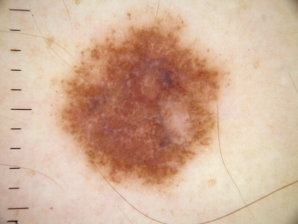

In [157]:
img_path = train_imgs.ls()[0]

img = open_image(img_path)

t = img.data

f_image = torch.rfft(t,signal_ndim=3,onesided=True)

f_image[:,:,:,1].mul_(1);

recon = torch.irfft(f_image,3, onesided=True, signal_sizes=t.shape)

torchvision.transforms.ToPILImage()(recon)

In [112]:
t = torch.rand(4,4)

In [113]:
t.random_()

tensor([[16747303., 10806468., 12747137.,  1810993.],
        [ 8732258.,  8735134.,  7615225.,  7894978.],
        [13351620.,  3342875.,  7252175., 12195860.],
        [ 4557780.,  1008042.,  9502546., 15592752.]])

In [209]:
from torchvision.models.resnet import Bottleneck
import types

In [320]:
r50 = models.resnet50(pretrained=True)
alpha_initial_value = 1.0
beta_initial_value = 1.0
gamma_initial_value = 1.0
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        f_image = torch.rfft(identity,signal_ndim=3,onesided=True)

        f_image[:,:,:,:,1].mul_(self.alpha);
        f_image[:,:,:,:,0].mul_(self.beta);

        recon = torch.irfft(f_image,3, onesided=True, signal_sizes=out.shape[1:])
        
        
        out = out + (self.gamma * recon)

        out = self.relu(out)

        return out

def add_fattn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_fattn_params(a_module):
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    a_module.beta = nn.Parameter(torch.tensor(beta_initial_value))
    a_module.gamma = nn.Parameter(torch.tensor(gamma_initial_value))

    print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_fattn_params(a_module)
    add_fattn_to_forward_func(a_module)

In [321]:
apply_leaf(r50, change_basic_blocks)

Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Added attention to Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

In [292]:
from exp import *

dm = DatasetManager('2017',224,'all','2017')

# dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

In [293]:
len(dm.get_dataset_path('train_images').ls())

2000

In [294]:
len(dm.get_dataset_path('valid_images').ls())

150

In [322]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(dm)

In [ ]:
data.show_batch(3)

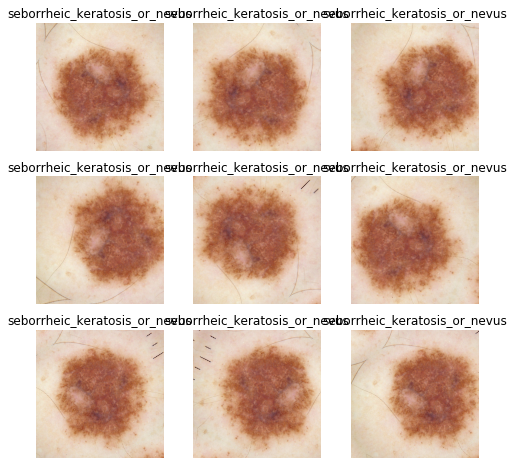

In [244]:
def _plot(i,j,ax,img_index=0):
    x,y = data.train_ds[img_index]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [245]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Lets test a baseline

In [323]:
data = reload_dataset(dm)

In [324]:
bottlenecks = [bn for bn in r50.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()
class Betas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.beta.item(),m.beta.item()
class Gammas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.gamma.item(),m.gamma.item()

In [325]:
bottlenecks[0].alpha

Parameter containing:
tensor(1., requires_grad=True)

In [326]:
random_seed(1,True)
learn = cnn_learner(data, lambda x: r50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=bottlenecks),
                                    partial(Betas, modules=bottlenecks),
                                    partial(Gammas, modules=bottlenecks),

                                      
], 
                        pretrained=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.210351,0.770072,0.360000,0.640000,0.617778,00:09
1,1.064224,0.636441,0.353333,0.646667,0.673333,00:09
2,0.925013,0.608679,0.313333,0.686667,0.659167,00:09
3,0.839510,0.630742,0.333333,0.666667,0.645833,00:09


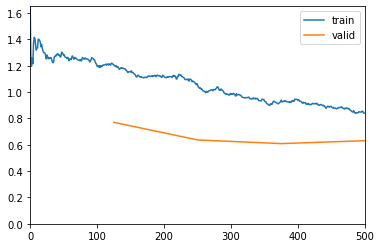

In [327]:
random_seed(1,True)
learn.fit_one_cycle(4,max_lr=slice(1.10E-04))

In [328]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239595,0.584804,0.293333,0.706667,0.663333,00:12
1,0.105761,0.590901,0.300000,0.700000,0.691667,00:12
2,0.377470,0.694060,0.320000,0.680000,0.570278,00:12
3,0.705321,0.685300,0.266667,0.733333,0.578889,00:12
4,0.694995,0.608833,0.226667,0.773333,0.613333,00:12
5,0.615181,0.559765,0.213333,0.786667,0.649444,00:12
6,0.570431,0.568469,0.226667,0.773333,0.684167,00:12
7,0.548726,0.546139,0.220000,0.780000,0.685556,00:12
8,0.585226,0.546953,0.226667,0.773333,0.699722,00:12
9,0.571054,0.521419,0.193333,0.806667,0.711389,00:12


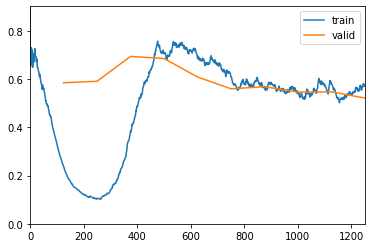

In [329]:
random_seed(1,True)
learn.fit_one_cycle(10,max_lr=slice(1.10E-04))

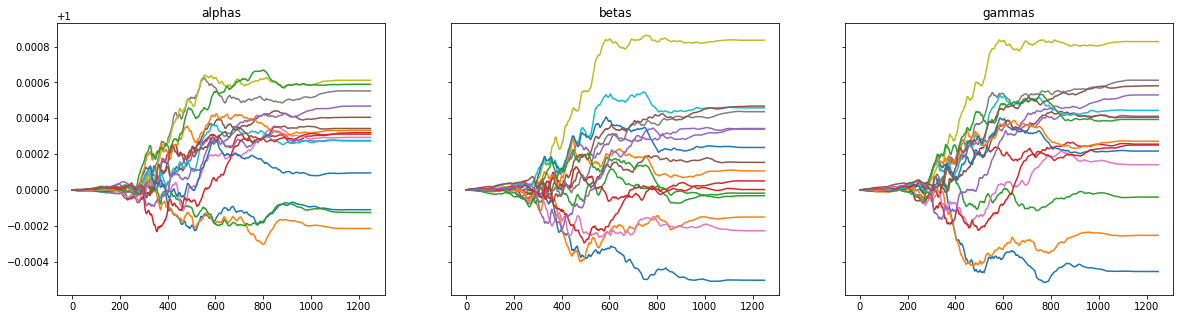

In [330]:
ps = list(learn.model.named_parameters())

ls = [n for n in ps if 'gamma' in n[0]]
new_params = ['alphas','betas','gammas']

fig, axs = plt.subplots(1,3,figsize=(20,5), sharey=True)
for idx, ax in enumerate(axs):
    for i in range(len(ls)):
        ax.plot(learn.__getattribute__(new_params[idx]).stats[0][i])
        ax.set_title(new_params[idx])

In [331]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.210329,0.770039,0.360000,0.640000,0.617500,00:05
1,1.063902,0.636237,0.353333,0.646667,0.674722,00:05
2,0.924814,0.608010,0.313333,0.686667,0.659444,00:05
3,0.839407,0.630412,0.333333,0.666667,0.645555,00:05


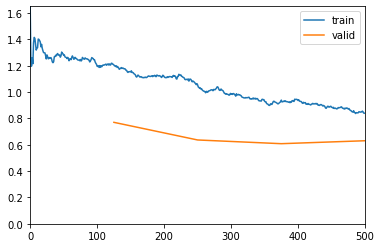

In [332]:
random_seed(1,True)
learn.fit_one_cycle(4,max_lr=slice(1.10E-04))

In [333]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239838,0.584440,0.293333,0.706667,0.662778,00:07
1,0.105818,0.591607,0.306667,0.693333,0.691389,00:07
2,0.373008,0.699061,0.320000,0.680000,0.561944,00:07
3,0.690484,0.679354,0.293333,0.706667,0.592778,00:07
4,0.672686,0.639764,0.226667,0.773333,0.595833,00:07
5,0.625732,0.591653,0.213333,0.786667,0.632778,00:07
6,0.566788,0.622482,0.226667,0.773333,0.661111,00:07
7,0.548385,0.536900,0.220000,0.780000,0.704444,00:07
8,0.585224,0.557657,0.213333,0.786667,0.700556,00:07
9,0.562268,0.520254,0.213333,0.786667,0.722778,00:07


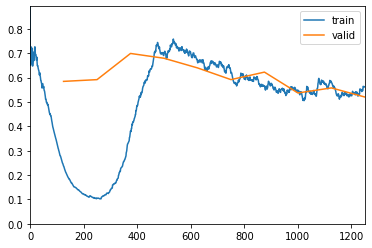

In [334]:
random_seed(1,True)
learn.fit_one_cycle(10,max_lr=slice(1.10E-04))